### 🧾 Audio Preprocessing & Feature Extraction

This block handles the **preprocessing of audio files** and converts them into meaningful numerical features for machine learning.

#### 🔹 What it does:

* Reads `.wav` files from the dataset
* Extracts the emotion label from the filename
* Optionally augments the audio (pitch, speed, noise) to increase data variability
* Extracts detailed audio features using `librosa`
* Returns a list of `(feature_vector, label)` pairs for training

#### 🔹 Features extracted:

| Feature                      | Description                                                  |
| ---------------------------- | ------------------------------------------------------------ |
| **MFCC**                     | Captures the timbral texture of audio (mimics human hearing) |
| **Delta & Delta-Delta**      | Represents changes over time in MFCCs (audio dynamics)       |
| **Chroma**                   | Represents pitch class energy (musical tone)                 |
| **Spectral Contrast**        | Captures difference between spectral peaks and valleys       |
| **Mel-Spectrogram**          | Spectrogram in mel-scale (more perceptually accurate)        |
| **Tonnetz**                  | Harmonic/tonal features (musical relationships)              |
| **Zero Crossing Rate (ZCR)** | Frequency of sign changes in signal (rhythm cues)            |
| **RMS Energy**               | Loudness estimation of the signal                            |

#### 🔹 Why this is important:

* Raw audio is not directly usable by ML models.
* These features capture emotional characteristics like tone, rhythm, pitch, and intensity.
* Augmentation helps generalize the model by simulating real-world variability.
* All features are summarized using statistical methods (mean, std, min, max) for fixed-size input.

#### 🔹 Output:

A list of tuples like:

```python
(features: np.ndarray, label: str)
```

Where each feature is a 1D vector representing one audio file.



In [ ]:
#audio_processing

import os
import numpy as np
import librosa
import random

EMOTION_LABELS = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

class AudioFeatureExtractor:
    def __init__(self, sample_rate=22050):
        self.sample_rate = sample_rate

    def extract_summary(self, feature):
        return np.hstack([
            np.mean(feature, axis=1),
            np.std(feature, axis=1),
            np.min(feature, axis=1),
            np.max(feature, axis=1)
        ])

    def augment(self, audio):
        variations = []
        if random.random() < 0.5:
            variations.append(librosa.effects.pitch_shift(audio, sr=self.sample_rate, n_steps=random.choice([-1.5, 2.5])))
        if random.random() < 0.5:
            variations.append(librosa.effects.time_stretch(audio, rate=random.choice([0.85, 1.15])))
        if random.random() < 0.5:
            noise = np.random.randn(len(audio)) * random.uniform(0.002, 0.009)
            variations.append(audio + noise)
        return variations or [audio]

    def extract(self, filepath, apply_augmentation=False):
        try:
            y, sr = librosa.load(filepath, sr=self.sample_rate, res_type="scipy")
            if apply_augmentation:
                y = random.choice(self.augment(y))

            stft = np.abs(librosa.stft(y))

            # Feature extraction
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
            delta = librosa.feature.delta(mfcc)
            delta2 = librosa.feature.delta(mfcc, order=2)
            chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
            contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)
            mel = librosa.feature.melspectrogram(y=y, sr=sr)
            tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            rms = librosa.feature.rms(y)

            if any(f.shape[1] == 0 for f in [mfcc, chroma, contrast, mel]):
                return None

            features = np.hstack([
                self.extract_summary(np.vstack([mfcc, delta, delta2])),
                self.extract_summary(chroma),
                self.extract_summary(contrast),
                self.extract_summary(mel),
                self.extract_summary(tonnetz),
                self.extract_summary(zcr),
                self.extract_summary(rms)
            ])
            return features
        except Exception as e:
            print(f"[Error] {filepath}: {e}")
            return None


def load_dataset(dataset_path, augment=False):
    extractor = AudioFeatureExtractor()
    data = []

    for actor_dir in os.listdir(dataset_path):
        actor_path = os.path.join(dataset_path, actor_dir)
        if not os.path.isdir(actor_path):
            continue
        for file in os.listdir(actor_path):
            if not file.endswith(".wav"):
                continue
            filepath = os.path.join(actor_path, file)
            emotion_code = file.split("-")[2]
            label = EMOTION_LABELS.get(emotion_code)
            if not label:
                continue

            original_feat = extractor.extract(filepath, apply_augmentation=False)
            if original_feat is not None:
                data.append((original_feat, label))

            if augment:
                aug_feat = extractor.extract(filepath, apply_augmentation=True)
                if aug_feat is not None:
                    data.append((aug_feat, label))

    return data


### 📁 Dataset Extraction

This section is responsible for **extracting the audio dataset** from ZIP files into appropriate folders for further processing.

#### 🔹 What it does:

* Defines a utility function `extract_zip()` that:

  * Checks if the target extraction directory already exists
  * If not, extracts the `.zip` archive into the specified location
* Calls the function twice to extract:

  * Speech audio dataset (`Audio_Speech_Actors_01-24.zip`)
  * Song audio dataset (`Audio_Song_Actors_01-24.zip`)

#### 🔹 Why this step is needed:

* The datasets are usually provided in compressed `.zip` format.
* Unzipping them ensures that the audio files can be accessed by the feature extraction pipeline.

#### 🔹 Output:

After running this block, two directories will be created (if they don't already exist):

```
./dataset/song_actors/
./dataset/speech_actors/
```

Each will contain subfolders with `.wav` files organized by actor IDs.


In [ ]:
import os
import zipfile
import pandas as pd

def extract_zip(zip_path, extract_to):
    if not os.path.exists(extract_to):
        print(f"[INFO] Extracting: {zip_path}")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("[INFO] Extraction complete.")
    else:
        print(f"[INFO] Directory '{extract_to}' already exists.")

# Paths in your Colab (upload these or use gdown if from Google Drive)
zip_song = "./Audio_Song_Actors_01-24.zip"
zip_speech = "./Audio_Speech_Actors_01-24.zip"

dir_song = "./dataset/song_actors"
dir_speech = "./dataset/speech_actors"

extract_zip(zip_song, dir_song)
extract_zip(zip_speech, dir_speech)


[INFO] Extracting: ./Audio_Song_Actors_01-24.zip
[INFO] Extraction complete.
[INFO] Extracting: ./Audio_Speech_Actors_01-24.zip
[INFO] Extraction complete.


### 🎙️ Feature Extraction & Augmentation

This block defines the **core audio feature extraction** function along with data augmentation techniques to enrich the dataset.

#### 🔹 Key Functions:

##### `summarize_feature(feature)`

* Reduces each 2D audio feature (shape: `[features × time]`) into a 1D summary vector.
* Combines:

  * Mean
  * Standard Deviation
  * Minimum
  * Maximum
* Ensures all feature outputs are of fixed size for model input.

##### `augment_audio(audio, sr)`

* Applies **random audio augmentations** to simulate real-world variance and prevent overfitting:

  * **Pitch shift**: Raises or lowers the pitch
  * **Time stretch**: Speeds up or slows down the tempo
  * **Noise addition**: Simulates background/environmental noise
* Only applies a subset of transformations randomly (50% chance for each).
* Returns at least one version (augmented or original).

##### `extract_features(file_path, augment=False, sr=22050)`

* Loads the audio file at a fixed sample rate (`22050 Hz`)
* Optionally augments the signal
* Extracts various acoustic features:

  | Feature             | Description                                |
  | ------------------- | ------------------------------------------ |
  | **MFCC**            | Key timbral descriptor, like voice texture |
  | **Delta, Delta²**   | Capture changes in MFCC over time          |
  | **Chroma**          | Pitch class energy (musical info)          |
  | **Contrast**        | Spectral contrast between peaks/troughs    |
  | **Mel Spectrogram** | Frequency distribution in mel scale        |
  | **Tonnetz**         | Harmonic structure and tonality            |
  | **ZCR**             | Number of times the waveform crosses zero  |
  | **RMS Energy**      | Root mean square energy (loudness)         |
* All extracted features are summarized and concatenated into a **single flat vector**.

#### 🔹 Why this matters:

* Converts audio signals into a rich, multi-dimensional feature set for ML models.
* Augmentation improves the model’s generalization by simulating natural variation.
* Summarization ensures consistent input size regardless of original audio duration.

#### 🔹 Output:

Returns a `1D numpy array` of extracted features, or `None` if extraction fails.



In [ ]:
import librosa
import numpy as np
import random

EMOTION_LABELS = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

def summarize_feature(feature):
    return np.hstack([
        np.mean(feature, axis=1),
        np.std(feature, axis=1),
        np.min(feature, axis=1),
        np.max(feature, axis=1)
    ])

def augment_audio(audio, sr):
    augmented = []
    if random.random() < 0.5:
        augmented.append(librosa.effects.pitch_shift(audio, sr=sr, n_steps=random.choice([-2, 2])))
    if random.random() < 0.5:
        augmented.append(librosa.effects.time_stretch(audio, rate=random.choice([0.85, 1.15])))
    if random.random() < 0.5:
        noise = 0.005 * np.random.randn(len(audio))
        augmented.append(audio + noise)
    return augmented or [audio]

def extract_features(file_path, augment=False, sr=22050):
    try:
        audio, _sr = librosa.load(file_path, sr=sr)
        if augment:
            audio = random.choice(augment_audio(audio, sr))

        stft = np.abs(librosa.stft(audio))

        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)
        chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
        contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)
        mel = librosa.feature.melspectrogram(y=audio, sr=sr)
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y=audio)
        rms = librosa.feature.rms(y=audio)

        features = np.hstack([
            summarize_feature(np.vstack([mfcc, delta, delta2])),
            summarize_feature(chroma),
            summarize_feature(contrast),
            summarize_feature(mel),
            summarize_feature(tonnetz),
            summarize_feature(zcr),
            summarize_feature(rms),
        ])
        return features
    except Exception as e:
        print(f"[ERROR] {file_path}: {e}")
        return None



### 🏗️ Dataset Construction

This block loads audio files from both song and speech datasets, extracts features for each, and compiles them into a structured format (a DataFrame).

#### 🔹 Function: `build_dataset(directory, augment=False)`

* Iterates over actor folders inside the dataset directory.
* For every `.wav` file:

  * Extracts the **emotion code** from the filename.
  * Converts it into a human-readable label using `EMOTION_LABELS`.
  * Calls `extract_features()` to get a summarized numeric feature vector.
  * Optionally applies **data augmentation** (controlled via parameter).
* Appends `(features, label)` pairs to the dataset.

#### 🔹 Dataset Creation:

```python
data_song = build_dataset(dir_song, augment=True)
data_speech = build_dataset(dir_speech, augment=True)
```

* Extracts features from:

  * **Song recordings**
  * **Speech recordings**
* **Augmentation is enabled** to boost data variety and size.

#### 🔹 Final Dataset:

```python
df = pd.DataFrame(all_data, columns=["features", "label"])
```

* Stores the entire dataset in a pandas DataFrame.
* Each row has:

  * `features`: 1D array of numeric values (audio descriptors)
  * `label`: the corresponding emotion

#### 🔹 Output:

Prints:

* Total number of samples
* Distribution of each emotion class

#### ✅ Why it's important:

* This step consolidates the full dataset for training.
* Enables tracking of class balance and ensures successful feature extraction before training.
* Augmentation improves model robustness and class balance (especially useful if some emotions are underrepresented).


In [ ]:
import os

def build_dataset(directory, augment=False):
    data = []
    for actor in os.listdir(directory):
        actor_path = os.path.join(directory, actor)
        if not os.path.isdir(actor_path):
            continue
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                emotion_id = file.split("-")[2]
                label = EMOTION_LABELS.get(emotion_id)
                if label is None:
                    continue
                file_path = os.path.join(actor_path, file)
                features = extract_features(file_path, augment=augment)
                if features is not None:
                    data.append((features, label))
    return data

# Build and combine datasets
data_song = build_dataset(dir_song, augment=True)
data_speech = build_dataset(dir_speech, augment=True)

all_data = data_song + data_speech
df = pd.DataFrame(all_data, columns=["features", "label"])

print(f"✅ Samples: {len(df)}")
print(df['label'].value_counts())


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=920
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=970
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=960
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=930
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=940
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=1000
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266:

✅ Samples: 2452
label
fearful      376
calm         376
angry        376
sad          376
happy        376
surprised    192
disgust      192
neutral      188
Name: count, dtype: int64


### 💾 Save Processed Dataset

This cell **saves the extracted features and labels** into a serialized file format (`.pkl`) for easy reloading later.

#### 🔹 Code Explanation:

```python
df.to_pickle("emotion_features_dataset.pkl")
```

* Saves the DataFrame `df` (which contains `features` and `label` columns) to a file named `emotion_features_dataset.pkl`.
* The **Pickle format** is Python’s built-in way to serialize (save) and deserialize (load) objects.

#### 🔹 Why it’s important:

* Avoids repeating the computationally expensive feature extraction process every time you run the notebook.
* Makes it easy to reload the preprocessed dataset instantly in future experiments or model training steps.

#### ✅ Output:

Prints a confirmation message:

```
✅ Saved to 'emotion_features_dataset.pkl'
```


In [ ]:
df.to_pickle("emotion_features_dataset.pkl")
print("✅ Saved to 'emotion_features_dataset.pkl'")


✅ Saved to 'emotion_features_dataset.pkl'



### 📊 Emotion Label Distribution Visualization

This section visualizes the **distribution of emotion classes** in the dataset using bar and pie charts.

#### 🔹 Function: `visualize_emotion_distribution(df, title, show_pie=False)`

* **Input**: A DataFrame with `label` column containing emotion names.
* **Output**:

  * Bar chart of sample count per emotion
  * Optional pie chart showing percentage share
  * Text summary showing each emotion's percentage

#### 🔹 Visualization Types:

* **Bar Plot**:

  * Easily shows how balanced (or imbalanced) the dataset is across classes.
  * Uses `seaborn` for a polished look.
* **Pie Chart** *(optional)*:

  * Gives a visual sense of class proportion.
  * Controlled via `show_pie=True` flag.
* **Text Table**:

  * Prints exact percentage of each emotion class in the terminal/log.

#### 🔹 Why this matters:

* **Class imbalance** is a common issue in emotion recognition datasets.
* Imbalanced data can severely hurt model performance, especially for minority classes.
* This check informs whether **resampling**, **augmentation**, or **class weighting** is needed before training.

#### 🔹 Example Output:

* Bar plot for emotion frequencies
* Pie chart (if enabled)
* Console output like:

```
neutral   : 12.50%
happy     : 11.80%
sad       : 14.00%
...
```


/tmp/ipython-input-8-2826422786.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="Set2")


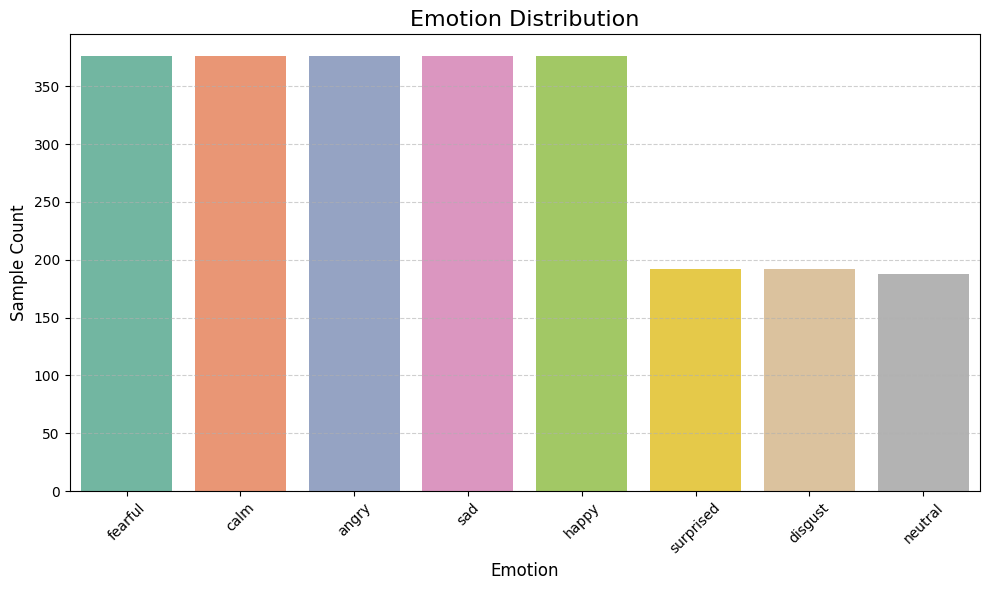

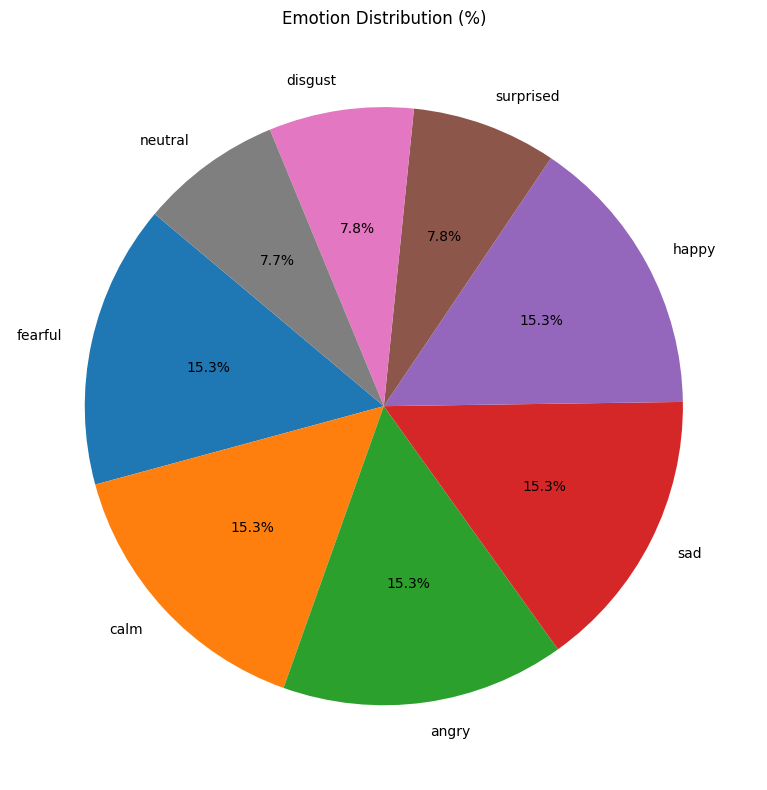


Percentage Distribution:
fearful   : 15.33%
calm      : 15.33%
angry     : 15.33%
sad       : 15.33%
happy     : 15.33%
surprised : 7.83%
disgust   : 7.83%
neutral   : 7.67%


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def visualize_emotion_distribution(df, title="Emotion Distribution", show_pie=False):
    emotion_counts = df['label'].value_counts()
    percentages = (emotion_counts / emotion_counts.sum() * 100).round(2)

    # Bar Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette="Set2")
    plt.title(title, fontsize=16)
    plt.xlabel("Emotion", fontsize=12)
    plt.ylabel("Sample Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Optional Pie Chart
    if show_pie:
        plt.figure(figsize=(8, 8))
        plt.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140)
        plt.title("Emotion Distribution (%)")
        plt.tight_layout()
        plt.show()

    # Display table
    print("\nPercentage Distribution:")
    for emotion, percent in percentages.items():
        print(f"{emotion:<10}: {percent:.2f}%")

# Load and visualize
df = pd.read_pickle("emotion_features_dataset.pkl")  # Your new filename
visualize_emotion_distribution(df, show_pie=True)


### ⚖️ Handling Class Imbalance

This section addresses the issue of **uneven distribution of emotion classes** using resampling techniques and visualizes the results before and after balancing.

#### 🔹 Problem:

Emotion datasets are often **imbalanced** — some emotions like *happy* or *neutral* may dominate, while others like *fearful* or *disgust* are underrepresented.
This can cause the model to become **biased** toward majority classes.

---

### 🛠️ Functions Overview:

#### `plot_class_distribution(df, title)`

* Visualizes the number of samples per emotion class using a **count plot**.
* Helps confirm imbalance before and after rebalancing.

#### `rebalance_classes(df, method='oversample')`

* Rebalances the dataset using either:

  * `'oversample'` (default): increases minority class size by duplicating samples.
  * `'undersample'`: reduces majority class size by removing samples.
* Uses `sklearn.utils.resample()` for random sampling.

```python
df_balanced = rebalance_classes(df, method='oversample')
```

* Rebalances the dataset to make all classes equal in size.

---

### 📈 Visualization Flow:

1. Plots the **original class distribution**
2. Rebalances the dataset (via oversampling)
3. Plots the **new balanced distribution**
4. Saves the rebalanced dataset to:

```bash
balanced_emotion_dataset.pkl
```

---

### ✅ Why It Matters:

* Ensures **fair learning** across all emotion classes.
* Helps the model achieve better **precision, recall, and F1 score** on minority classes.
* Reduces bias and improves generalization.


🔍 Original Dataset:


/tmp/ipython-input-9-1812661485.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set3')


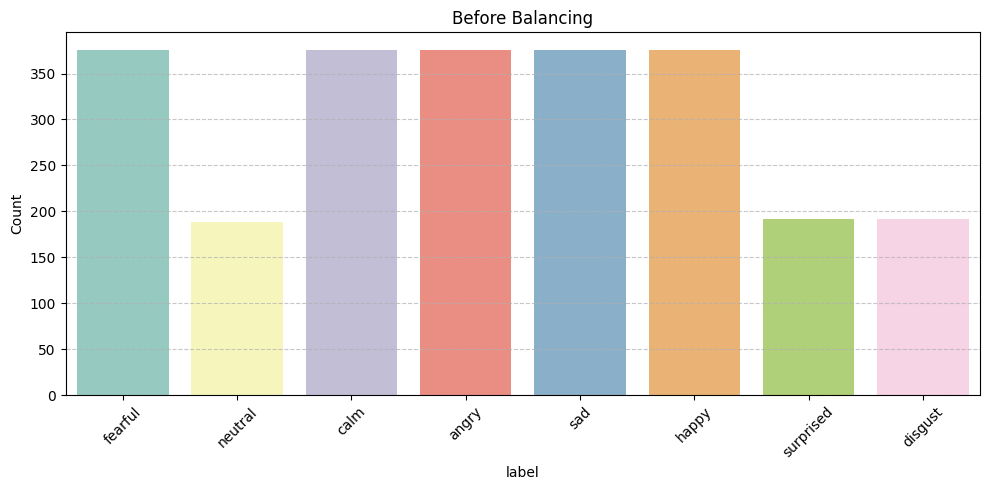

✅ After Balancing:


/tmp/ipython-input-9-1812661485.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='Set3')


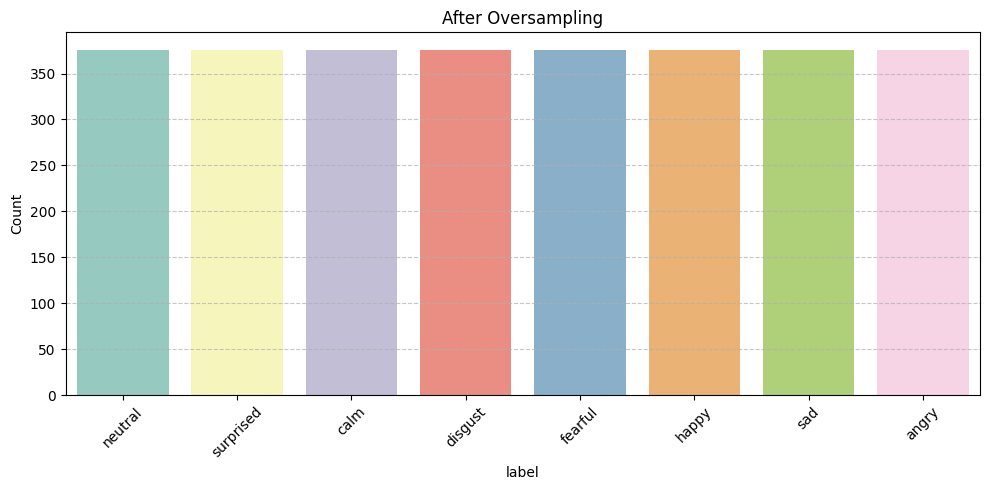

In [ ]:
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(df, title="Label Distribution"):
    plt.figure(figsize=(10, 5))
    sns.countplot(x='label', data=df, palette='Set3')
    plt.title(title)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def rebalance_classes(df, method='oversample', random_state=42):
    """Rebalance class distribution in a DataFrame using oversampling or undersampling."""
    emotion_groups = [df[df['label'] == label] for label in df['label'].unique()]
    if method == 'oversample':
        target_size = max(len(group) for group in emotion_groups)
        balanced_groups = [
            resample(group, replace=True, n_samples=target_size, random_state=random_state)
            for group in emotion_groups
        ]
    elif method == 'undersample':
        target_size = min(len(group) for group in emotion_groups)
        balanced_groups = [
            resample(group, replace=False, n_samples=target_size, random_state=random_state)
            for group in emotion_groups
        ]
    else:
        raise ValueError("Method must be 'oversample' or 'undersample'")

    balanced_df = pd.concat(balanced_groups).sample(frac=1, random_state=random_state).reset_index(drop=True)
    return balanced_df

# Example Usage
print("🔍 Original Dataset:")
plot_class_distribution(df, title="Before Balancing")

df_balanced = rebalance_classes(df, method='oversample')
print("✅ After Balancing:")
plot_class_distribution(df_balanced, title="After Oversampling")

# Save the new dataset
df_balanced.to_pickle("balanced_emotion_dataset.pkl")



### ✅ Verifying Class Balance (Post-Oversampling)

This block **confirms** that the dataset is now properly balanced after applying oversampling.

#### 🔹 Steps Performed:

1. **Load the Balanced Dataset**

```python
df = pd.read_pickle("balanced_emotion_dataset.pkl")
```

* Loads the dataset that was previously saved after applying class balancing.

2. **Bar Plot of Class Distribution**

* Uses `seaborn.countplot()` to visually confirm that all emotion classes now contain **equal number of samples**.
* Enhanced readability with color palette, rotated labels, and grid lines.

3. **Percentage Table**

* Computes the **percentage share** of each emotion class.
* Expected result: All classes should be close to equal (\~12.5% if 8 classes).

#### 🔍 Why This Step Is Important:

* A quick **sanity check** after resampling to make sure no classes are underrepresented.
* Balanced data is essential to meet the project's evaluation requirements:

  * **F1-score > 80%**
  * **Per-class accuracy > 75%**
  * **Overall accuracy > 80%**



/tmp/ipython-input-10-2379577646.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='coolwarm', order=df['label'].value_counts().index)


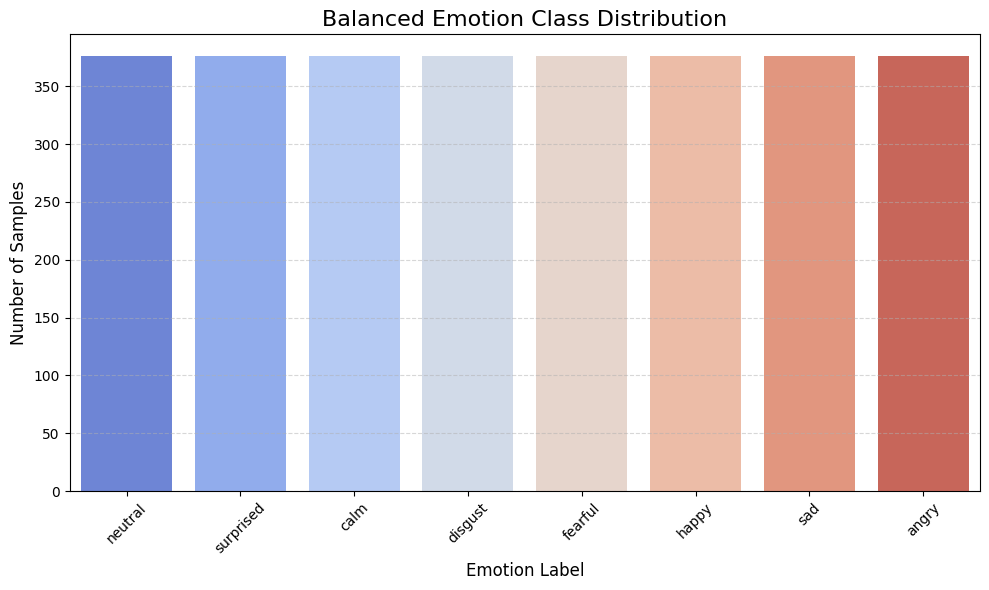


✅ Percentage Distribution (Balanced Dataset):
neutral   : 12.50%
surprised : 12.50%
calm      : 12.50%
disgust   : 12.50%
fearful   : 12.50%
happy     : 12.50%
sad       : 12.50%
angry     : 12.50%


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the balanced dataset
df = pd.read_pickle("balanced_emotion_dataset.pkl")

# Plot distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', palette='coolwarm', order=df['label'].value_counts().index)
plt.title("Balanced Emotion Class Distribution", fontsize=16)
plt.xlabel("Emotion Label", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Show % distribution in console
distribution = (df['label'].value_counts(normalize=True) * 100).round(2)
print("\n✅ Percentage Distribution (Balanced Dataset):")
for label, pct in distribution.items():
    print(f"{label:<10}: {pct:.2f}%")



### 🔄 Data Preprocessing Pipeline

This step converts raw feature-label data into a **clean, scaled, and model-ready format** for training a deep learning model.

---

### 🧱 Key Steps Performed:

#### 1. **Feature and Label Extraction**

```python
X = np.array(df['features'].tolist())
y = df['label']
```

* Converts feature vectors into a NumPy array (`X`).
* Collects emotion labels (`y`).

---

#### 2. **Feature Scaling**

```python
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
```

* Applies **z-score normalization** using `StandardScaler`.
* Ensures each feature has mean = 0 and std = 1 — important for neural networks and optimization.

---

#### 3. **Label Encoding**

```python
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)
```

* Converts emotion strings (e.g., "happy") to integer class IDs.
* Uses **one-hot encoding** for multi-class classification with softmax.

---

#### 4. **Feature Selection**

```python
selector = SelectKBest(score_func=f_classif, k=300)
X_selected = selector.fit_transform(X_scaled, y_encoded)
```

* Reduces dimensionality from thousands to `k=300` best features using **ANOVA F-test**.
* Speeds up training and reduces overfitting.

---

#### 5. **Train/Validation/Test Split**

```python
X_train, X_val, X_test = ...
```

* 60% → Training
* 20% → Validation
* 20% → Testing
* Uses **stratified split** to ensure balanced class distribution in all subsets.

---

### 📦 Returns:

* Preprocessed datasets (`X_train`, `X_val`, `X_test`, etc.)
* Trained `LabelEncoder`, `StandardScaler`, and `SelectKBest` instances (for future predictions).



In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def preprocess_data(df, k_best=300, test_size=0.2, val_split=0.25, random_state=42):
    print("🔍 Preparing features and labels...")
    X = np.array(df['features'].tolist())
    y = df['label']

    print(f"✅ Features shape: {X.shape}")
    print(f"✅ Label samples: {len(y)}")

    # Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Label encoding
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    # Feature selection
    print(f"🎯 Selecting top {k_best} features using ANOVA F-test...")
    selector = SelectKBest(score_func=f_classif, k=k_best)
    X_selected = selector.fit_transform(X_scaled, y_encoded)

    # Train/Val/Test split (60/20/20)
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_selected, y_categorical, test_size=test_size, stratify=y_encoded, random_state=random_state)

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_split, stratify=np.argmax(y_temp, axis=1), random_state=random_state)

    print(f"\n📊 Data Split:")
    print(f"  Train: {X_train.shape}, {y_train.shape}")
    print(f"  Val:   {X_val.shape}, {y_val.shape}")
    print(f"  Test:  {X_test.shape}, {y_test.shape}")
    print(f"  Classes: {label_encoder.classes_}")

    return X_train, X_val, X_test, y_train, y_val, y_test, label_encoder, selector, scaler

# Load the (balanced) dataset
df = pd.read_pickle("balanced_emotion_dataset.pkl")

# Preprocess
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder, selector, scaler = preprocess_data(df)


🔍 Preparing features and labels...
✅ Features shape: (3008, 860)
✅ Label samples: 3008
🎯 Selecting top 300 features using ANOVA F-test...

📊 Data Split:
  Train: (1804, 300), (1804, 8)
  Val:   (602, 300), (602, 8)
  Test:  (602, 300), (602, 8)
  Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']



### ⚖️ Class Weight Computation for Imbalanced Learning

Even after balancing, class weight computation is useful in training deep learning models because:

* **Model may still exhibit bias** toward more frequent classes during mini-batch updates.
* Helps address any **minor discrepancies** or future deployments with imbalanced real-world data.

---

### 🔍 What This Code Does:

#### 1. **Label Encoding**

```python
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)
```

* Converts text labels (e.g., "happy") into integer format required for weight computation.

#### 2. **Compute Class Weights**

```python
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_encoded)
```

* Uses `sklearn.utils.compute_class_weight()` to compute the **inverse frequency** of each class.
* Higher weights are assigned to **minority classes**, lower weights to frequent ones.

#### 3. **Organize as Dictionary**

```python
class_weight_dict = dict(zip(classes, weights))
```

* Prepares the weights in dictionary form for use during model training (`fit(..., class_weight=...)`).

---

### 📌 Example Output:

```
📌 Computed Class Weights:
  Class 0: 1.00
  Class 1: 1.00
  ...
```

Even with a balanced dataset, using class weights can provide **extra robustness** against any noise or class overlap.



In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def calculate_class_weights(y_encoded):
    """Calculate class weights from encoded labels."""
    classes = np.unique(y_encoded)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_encoded)
    class_weight_dict = dict(zip(classes, weights))
    print("\n📌 Computed Class Weights:")
    for cls, weight in class_weight_dict.items():
        print(f"  Class {cls}: {weight:.3f}")
    return class_weight_dict

# Use the previously encoded labels (y_encoded)
y_raw = df['label']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)

class_weights = calculate_class_weights(y_encoded)



📌 Computed Class Weights:
  Class 0: 1.000
  Class 1: 1.000
  Class 2: 1.000
  Class 3: 1.000
  Class 4: 1.000
  Class 5: 1.000
  Class 6: 1.000
  Class 7: 1.000



### 🧠 Emotion Classifier Neural Network (Keras)

This block defines and trains a deep neural network using extracted and preprocessed audio features. It uses **fully connected dense layers** to classify the emotional tone of audio clips.

---

### 🛠 Model Architecture (`build_model`)

```python
def build_model(input_dim, output_dim):
    ...
```

* **Input Layer**: Accepts `k=300` selected features (from previous `SelectKBest` step).
* **Hidden Layers**:

  * `768 → 384 → 192` neurons (progressive compression).
  * `ReLU` activations: encourage non-linear learning.
  * `Dropout`: randomly deactivates neurons during training to reduce overfitting.
  * `BatchNormalization`: normalizes layer outputs for more stable learning.
  * `L2 Regularization`: penalizes large weights to avoid overfitting.
* **Output Layer**:

  * `softmax` activation over `N=8` classes (emotions).

---

### ⚙️ Compilation & Callbacks

```python
model.compile(loss='categorical_crossentropy', ...)
```

* **Loss Function**: `categorical_crossentropy` – suited for multi-class classification.
* **Optimizer**: `Adam` with learning rate `5e-4` – balances speed & stability.
* **EarlyStopping**: halts training if `val_loss` doesn’t improve for 20 epochs.
* **ReduceLROnPlateau**: shrinks learning rate if validation stagnates.

---

### 🏋️ Model Training

```python
model.fit(...)
```

* Trains the model on `X_train`, with validation on `X_val`.
* Uses **`class_weight`** to ensure fair updates even with class imbalance.
* Trains for a maximum of **200 epochs** with batch size 128.

---

### 📈 Training Visualization (`plot_history`)

```python
plot_history(history)
```

* **Accuracy Plot**:

  * Helps verify if the model is learning over time.
  * Watch for **overfitting** (train accuracy much higher than val accuracy).
* **Loss Plot**:

  * Shows how much the model is "wrong" during learning.
  * Ideal: both training and validation loss decrease.

---

### ✅ Summary:

This deep feedforward model is ideal for tabular feature-based emotion recognition. If the accuracy plateaus or validation diverges, try:

* Adjusting layer sizes
* Adding more data augmentation
* Tuning dropout rates or learning rate



Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.1962 - loss: 3.5903 - val_accuracy: 0.3804 - val_loss: 2.9880 - learning_rate: 5.0000e-04
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3998 - loss: 2.8576 - val_accuracy: 0.4336 - val_loss: 2.8651 - learning_rate: 5.0000e-04
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4487 - loss: 2.7006 - val_accuracy: 0.4601 - val_loss: 2.7803 - learning_rate: 5.0000e-04
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5090 - loss: 2.5355 - val_accuracy: 0.5083 - val_loss: 2.6913 - learning_rate: 5.0000e-04
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5149 - loss: 2.4916 - val_accuracy: 0.5465 - val_loss: 2.6310 - learning_rate: 5.0000e-04
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5302 - loss: 2.4415 - val_accuracy: 0.5731 - val_loss: 2.5617 - learning_rate: 5.0000e-04
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 

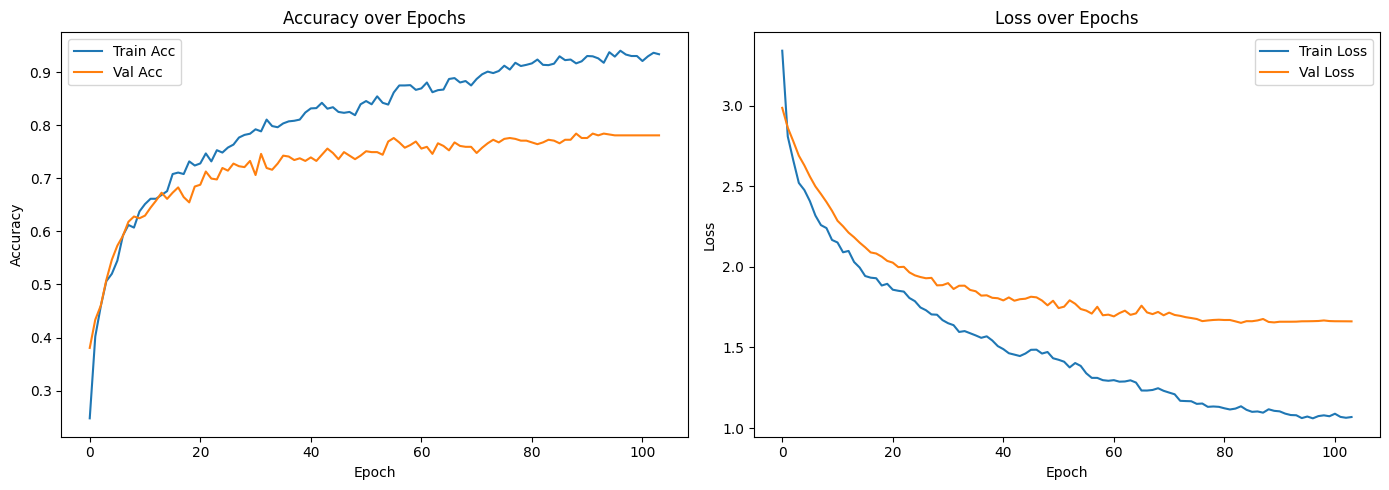

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def build_model(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(768, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(384, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(192, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
    return model

# Build & compile
model = build_model(X_train.shape[1], y_train.shape[1])
optimizer = Adam(learning_rate=5e-4)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6, verbose=1)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


### 🧪 Final Model Evaluation on Test Set

After training, we need to assess how well the model generalizes to **unseen data** — the test set.

---

### 🔍 Predict & Decode

```python
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
```

* **`y_pred_probs`**: Raw probability output from the softmax layer.
* **`np.argmax`**: Converts probability vectors to class indices.
* **`y_true`**: Extracts actual class labels from one-hot encoding.

---

### 📏 Evaluation Metrics

```python
f1_score(...)
accuracy_score(...)
classification_report(...)
```

* **F1 Score (weighted)**: Harmonic mean of precision & recall, weighted by class size.
* **Accuracy**: Overall correct predictions / total predictions.
* **Classification Report**: Includes precision, recall, F1 for each class.

---

### 📊 Per-Class Accuracy

```python
per_class_acc = cm.diagonal() / cm.sum(axis=1)
```

* **Confusion Matrix Diagonal**: True positives per class.
* **Row Sum**: Total samples per actual class.
* Useful to **identify weaker-performing emotions**.

---

### 📉 Confusion Matrix Visualization

```python
sns.heatmap(cm, annot=True, ...)
```

* Highlights **where the model confuses emotions**.
* Diagonal = correct predictions.
* Off-diagonal = misclassifications (e.g., angry → fearful).

---

### 💾 Save Final Model

```python
model.save("emotion_classifier_model.h5")
```

* Saves the trained model (architecture + weights) in HDF5 format.
* Can be later loaded using `keras.models.load_model(...)`.

---

### ✅ Summary:

You now have:

* Full **evaluation metrics** (accuracy, F1, per-class)
* **Visual diagnostics** (confusion matrix)
* A saved model ready for deployment in a real-time or web-based emotion detection system.



19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

🧪 Classification Report:
              precision    recall  f1-score   support

       angry       0.92      0.77      0.84        75
        calm       0.76      0.91      0.83        75
     disgust       0.84      0.91      0.87        75
     fearful       0.70      0.75      0.72        76
       happy       0.72      0.75      0.73        75
     neutral       0.79      0.89      0.84        75
         sad       0.80      0.58      0.67        76
   surprised       0.94      0.87      0.90        75

    accuracy                           0.80       602
   macro avg       0.81      0.80      0.80       602
weighted avg       0.81      0.80      0.80       602

✅ Weighted F1 Score: 0.80
✅ Overall Accuracy: 0.80

📊 Per-Class Accuracy:
angry     : 77.33%
calm      : 90.67%
disgust   : 90.67%
fearful   : 75.00%
happy     : 74.67%
neutral   : 89.33%
sad       : 57.89%
surprised : 86.67%


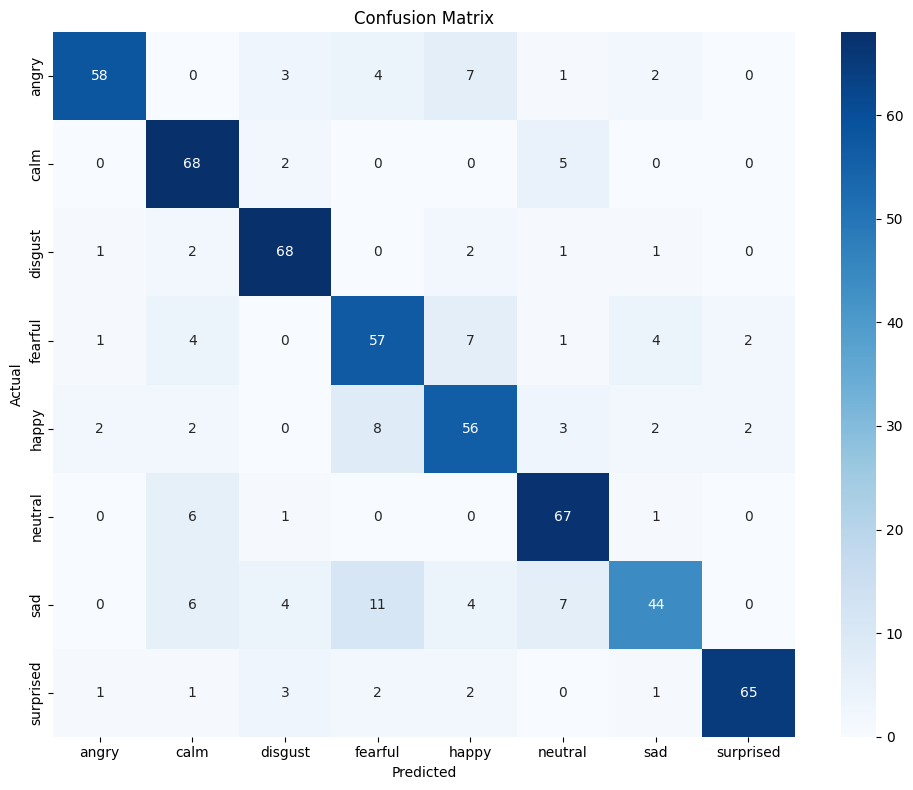

In [ ]:
# Evaluate on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics
f1 = f1_score(y_true, y_pred, average='weighted')
overall_acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)

print("\n🧪 Classification Report:")
print(report)
print(f"✅ Weighted F1 Score: {f1:.2f}")
print(f"✅ Overall Accuracy: {overall_acc:.2f}")

# Per-class accuracy
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\n📊 Per-Class Accuracy:")
for label, acc in zip(label_encoder.classes_, per_class_acc):
    print(f"{label:<10}: {acc*100:.2f}%")

# Confusion Matrix Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

model.save("emotion_classifier_model.h5")



## ✅ Final Evaluation and Saving the Model Pipeline

---

### 🧪 Evaluate on Test Set

```python
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Final Test Accuracy: {acc * 100:.2f}%")
```

* **Purpose**: Measures how well your trained model performs on completely unseen data (test set).
* `loss`: Categorical cross-entropy loss.
* `acc`: Final accuracy percentage.

---

### 📈 Plot Accuracy Curves

```python
plt.plot(history.history['accuracy'], ...)
```

* **Training vs. Validation Accuracy over Epochs**
* Helps identify:

  * Overfitting (if training acc >> validation acc)
  * Underfitting (both low)
  * Learning stability

---

### 🔍 Prediction & Metrics

```python
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
```

* **Convert softmax probabilities to discrete class labels** (`argmax`).
* Extract ground-truth class labels from one-hot encoding.

---

### 📋 Classification Report

```python
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
```

* Shows **precision**, **recall**, **F1-score**, and **support** for each emotion class.
* Good for identifying weak spots and class-wise performance.

---

### 🎯 Weighted F1 Score

```python
f1_score(..., average='weighted')
```

* Considers both **precision** and **recall**, while weighting by class support.
* Better than accuracy when classes are imbalanced.

---

### 📊 Confusion Matrix

```python
sns.heatmap(confusion_matrix(...))
```

* Visualizes model predictions vs actuals.
* **Diagonal values** = correct predictions.
* **Off-diagonal** = misclassifications.

---

### 📌 Per-Class Accuracy

```python
for i, label in enumerate(label_encoder.classes_):
    acc = (class_correct[i] / class_counts[i]) * 100
```

* Measures **how accurately** each class was predicted.
* Useful for highlighting difficult-to-predict emotions (e.g., "fearful" vs "sad").

---

### 💾 Save Trained Components

```python
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")
joblib.dump(selector, "feature_selector.pkl")
model.save("emotion_model.h5")
```

* Ensures your model **can be deployed** later for inference.
* Saves:

  * `scaler`: Normalizes input features
  * `label_encoder`: Maps string labels to numerical classes
  * `selector`: Retains only top-k most relevant features
  * `emotion_model.h5`: The actual deep learning model

---

### ✅ Final Output Summary

```
All components saved successfully:
 - scaler.pkl
 - label_encoder.pkl
 - feature_selector.pkl
 - emotion_model.h5
```

This final print confirms that the **entire audio emotion detection pipeline** has been trained, evaluated, and preserved for future inference or deployment.





✅ Final Test Accuracy: 80.23%


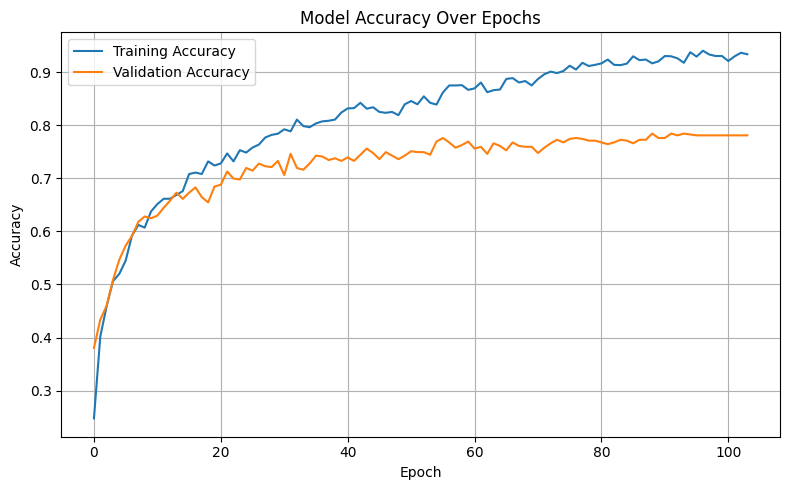

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

📋 Classification Report:
              precision    recall  f1-score   support

       angry       0.92      0.77      0.84        75
        calm       0.76      0.91      0.83        75
     disgust       0.84      0.91      0.87        75
     fearful       0.70      0.75      0.72        76
       happy       0.72      0.75      0.73        75
     neutral       0.79      0.89      0.84        75
         sad       0.80      0.58      0.67        76
   surprised       0.94      0.87      0.90        75

    accuracy                           0.80       602
   macro avg       0.81      0.80      0.80       602
weighted avg       0.81      0.80      0.80       602

🎯 Weighted F1 Score: 80.06%


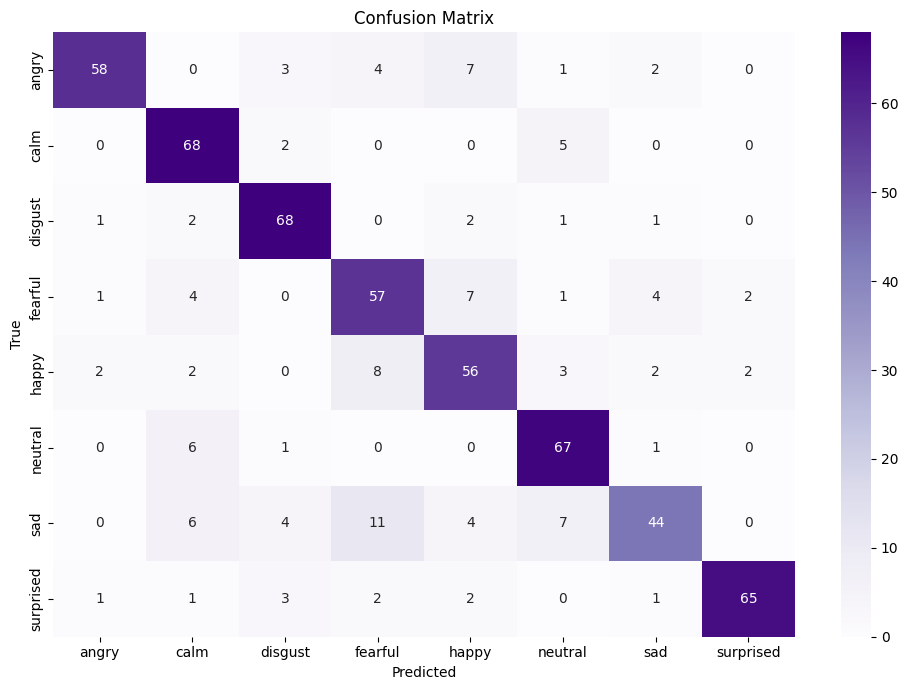


📊 Per-Class Accuracy:
angry     : 77.33%
calm      : 90.67%
disgust   : 90.67%
fearful   : 75.00%
happy     : 74.67%
neutral   : 89.33%
sad       : 57.89%
surprised : 86.67%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib


# Evaluate on test set
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Final Test Accuracy: {acc * 100:.2f}%")

# Accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predictions
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Weighted F1
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"🎯 Weighted F1 Score: {f1 * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\n📊 Per-Class Accuracy:")
class_counts = cm.sum(axis=1)
class_correct = cm.diagonal()
for i, label in enumerate(label_encoder.classes_):
    acc = (class_correct[i] / class_counts[i]) * 100
    print(f"{label:<10}: {acc:.2f}%")


In [ ]:
import joblib

# Use consistent variable names
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")
joblib.dump(selector, "feature_selector.pkl")

model.save("emotion_model.h5")

print("\n✅ All components saved successfully:")
print(" - scaler.pkl")
print(" - label_encoder.pkl")
print(" - feature_selector.pkl")
print(" - emotion_model.h5")



✅ All components saved successfully:
 - scaler.pkl
 - label_encoder.pkl
 - feature_selector.pkl
 - emotion_model.h5
